# Tests pour fusionner les deux masques

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%reload_ext autoreload

In [3]:
! pip install rasterio  -q -q -q
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q
! pip install pyarrow

In [4]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *
from mappings import *

In [5]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import re
from pyproj import Transformer
from datetime import date

In [6]:
update_storage_access()

environment = get_environment()

root_path = get_root_path()

bucket = environment["bucket"]

path_s3_pleiades_data_2022_guyane = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_pleiades_data_2022_guyane = environment["local-path"]["PLEIADES"][2022]["guyane"]

path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})



In [7]:
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_guyane}",
        lpath=f"../{path_local_pleiades_data_2022_guyane}",
        recursive=True)

fs.download(
        rpath=f"{bucket}/{path_s3_bdtopo_data}",
        lpath=f"../{path_local_bdtopo_data}",
        recursive=True
)


In [8]:
filename = '../data/PLEIADES/2022/GUYANE/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')

In [9]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = '973'
    )
image.normalize()

In [10]:
from labeler import RILLabeler
from labeled_satellite_image import SegmentationLabeledSatelliteImage

labeler_RIL = RILLabeler(date, '973')

In [10]:
import rasterio

In [11]:
mask_RIL = labeler_RIL.create_segmentation_label(image)

In [84]:
from labeler import BDTOPOLabeler
labeler_BDTOPO = BDTOPOLabeler(date, '973')

In [13]:
mask_BDTOPO = labeler_BDTOPO.create_segmentation_label(image)

In [14]:
import geopandas as gpd
from shapely.geometry import Polygon
from rasterio.features import rasterize, shapes

In [ ]:
image_height = image.array.shape[1]
image_width = image.array.shape[2]
polygon_list = []
for shape in list(shapes(mask_BDTOPO)):
    polygon = Polygon(shape[0]["coordinates"][0])
    if polygon.area > 0.85 * image_height * image_width:
        continue
    polygon_list.append(polygon)
    
# Créer un GeoSeries à partir de la liste de polygons
gdf_BDTOPO = gpd.GeoDataFrame(geometry = gpd.GeoSeries(polygon_list))

In [41]:
polygon_list = []
for shape in list(shapes(mask_RIL)):
    polygon = Polygon(shape[0]["coordinates"][0])
    if polygon.area > 0.85 * image_height * image_width:
        continue
    polygon_list.append(polygon)
 
# Créer un GeoSeries à partir de la liste de polygons
gdf_RIL = gpd.GeoDataFrame(geometry = gpd.GeoSeries(polygon_list))

In [ ]:
result = gpd.sjoin(gdf_BDTOPO, gdf_RIL,how="inner",predicate = "intersects")

In [48]:
results = result.drop_duplicates(subset='geometry')

In [56]:
g_result = results.geometry

<Axes: >

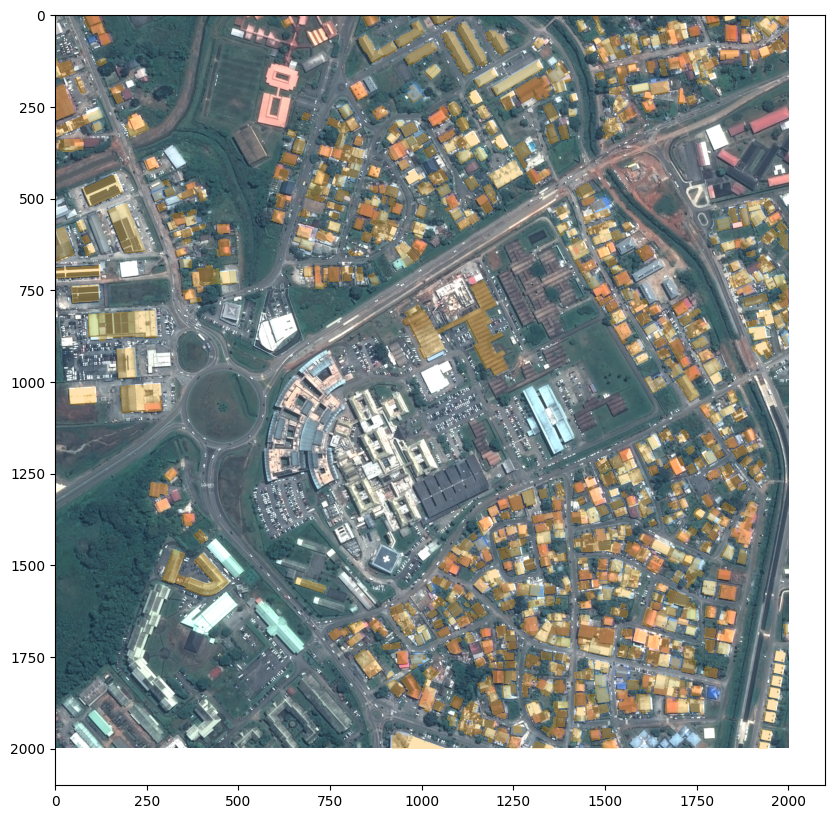

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
g_result.plot(color = "orange", ax=ax, alpha=0.3)

In [58]:
xmin, ymin, xmax, ymax = image.bounds

In [59]:
patch = labeler_BDTOPO.labeling_data.cx[xmin:xmax, ymin:ymax].copy()    

In [65]:
gdf_result['geometry_withoutZ'] = gdf_result.geometry.copy()

enlevons le Z pour faire le merge

In [ ]:
patch['geometry']
patch['geometry_withoutZ']

In [61]:
#fonction 1

# Définir une fonction pour enlever la coordonnée Z
def remove_z(coord):
    return (coord[0],coord[1])

# Appliquer la fonction à chaque polygone
patch['geometry_withoutZ'] = patch['geometry'].apply(lambda x: Polygon([remove_z(coord) for coord in x.exterior.coords]))


In [239]:
#fonction 2

from shapely.geometry import Polygon

# Fonction pour enlever la composante Z d'un polygon 3D
def remove_z(polygon):
    exterior_coords = [(x, y) for x, y, z in polygon.exterior.coords]
    interior_coords = []
    for interior in polygon.interiors:
        interior_coords.append([(x, y) for x, y, z in interior.coords])
    return Polygon(exterior_coords, interior_coords)

# Appliquer la fonction à la colonne de géométrie du GeoDataFrame
patch['geometry_withoutZ'] = patch['geometry'].apply(remove_z)

le merge ne marche avec aucune des fonctions... il ne manque plus que ca pour avoir le masque...

In [241]:
merged_gdf = patch.merge(gdf_result, on='geometry_withoutZ')

In [206]:
new_masque = rasterize(
                merged_gdf.geometry,
                out_shape=image.array.shape[1:],
                fill=0,
                out=None,
                transform=image.transform,
                all_touched=True,
                default_value=1,
                dtype=None,
                 )

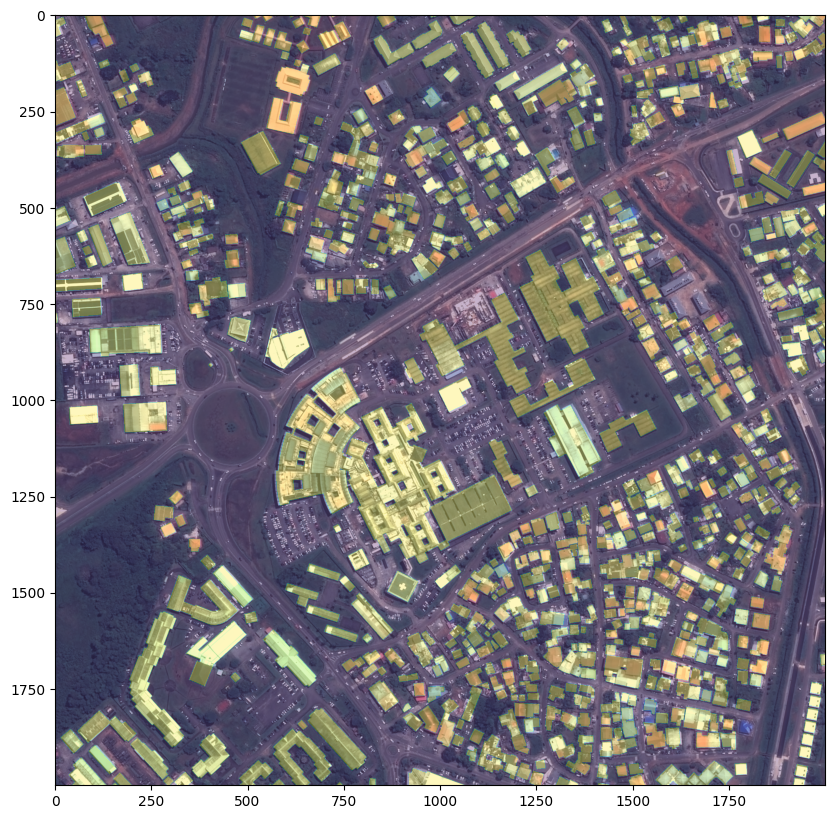

In [207]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
ax.imshow(new_masque, alpha=0.3)

### Codage de la fonction creer segementation mask pour RIL BDTOPO labeler

In [11]:
import datetime

In [19]:
from rasterio.features import rasterize, shapes

In [13]:
dep ="973"
image = image

extract_bdtopo = load_bdtopo(str(image.date.year),image.dep)
extract_ril = load_ril(str(image.date.year),image.dep)



In [20]:
xmin, ymin, xmax, ymax = image.bounds
patch_ril = extract_ril.cx[xmin:xmax, ymin:ymax].copy()
patch_bdtopo = extract_bdtopo.cx[xmin:xmax, ymin:ymax].copy()

patch = gpd.sjoin(patch_bdtopo, patch_ril,how="inner",predicate = "intersects")

patch.drop_duplicates(subset='geometry')

if patch.empty:
            rasterized = np.zeros(
                satellite_image.array.shape[1:], dtype=np.uint8
            )
else:
            rasterized = rasterize(
                patch.geometry,
                out_shape=image.array.shape[1:],
                fill=0,
                out=None,
                transform=image.transform,
                all_touched=True,
                default_value=1,
                dtype=None,
            )
            


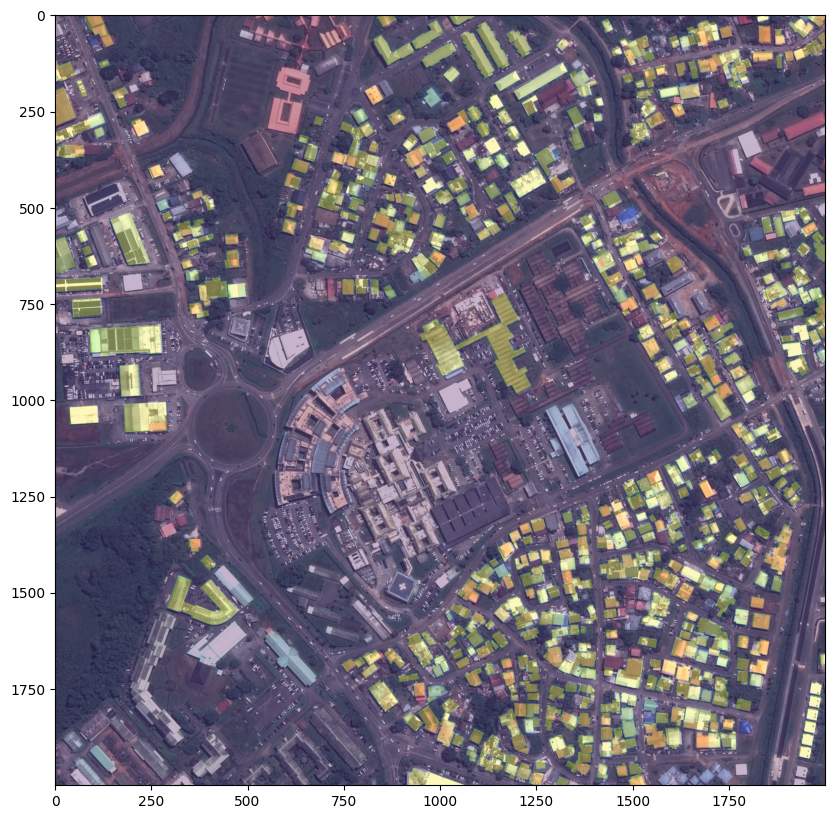

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
ax.imshow(rasterized, alpha=0.3)